# TCRD Target Visualizations

I am personally interested in the Targets that are in the Tdark stage that are on the brink of advancing because discovering things is much more exciting, so that will be the focus of this notebook.

In [1]:
# Importing what I will be using
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import warnings

warnings.filterwarnings('ignore')

targets = pd.read_pickle('Data/pharos_data')
generif = pd.read_pickle('Data/generif')
ortholog = pd.read_pickle('Data/ortholog')
pm_scores = pd.read_pickle('Data/pm_scores')
pt_scores = pd.read_pickle('Data/pt_scores')
ab_info = pd.read_pickle('Data/tdl_info')
goa = pd.read_pickle('Data/goa')
omim = pd.read_pickle('Data/omim')
hgram = pd.read_pickle('Data/hgram')

style.use('seaborn-poster')


The actual defined goals of the project are to find any Tdark targets that could be ready to achieve a new TDL level, and then potentially find new features that can also help indicate that a target is close to getting a new TDL level.

To start, I will try to find potential targets that are close to achieving a new TDL level via the defined requirements, and then compare those targets to each other to see if there are similar trends among those targets in the TCDR DB to see if I can find any new features which can also indicate a potential change in TDL level.

In [2]:
# Extracting only relevant information

targets = targets[targets['tdl'] == 'Tdark'].reset_index(drop=True)

pm_scores = pm_scores[pm_scores['protein_id'].isin(targets['id'])].reset_index(drop=True)
pt_scores = pt_scores[pt_scores['protein_id'].isin(targets['id'])].reset_index(drop=True)
generif = generif[generif['protein_id'].isin(targets['id'])].reset_index(drop=True)
ortholog = ortholog[ortholog['protein_id'].isin(targets['id'])].reset_index(drop=True)
ab_info = ab_info[ab_info['protein_id'].isin(targets['id'])].reset_index(drop=True)

I have filtered out all the data sets to only contain information on proteins that are Tdark, which will make it easier to compare and visualize

In [3]:
# Combine data from separate data frames into one
targets['ab_count'] = ab_info.integer_value

\pagebreak

# Looking at Tdark proteins

## Antibodies
I wonder how the antibody count is distributed among the different proteins

Text(0.5, 1.0, 'Distribution of Antibody Count Among Tdark Proteins')

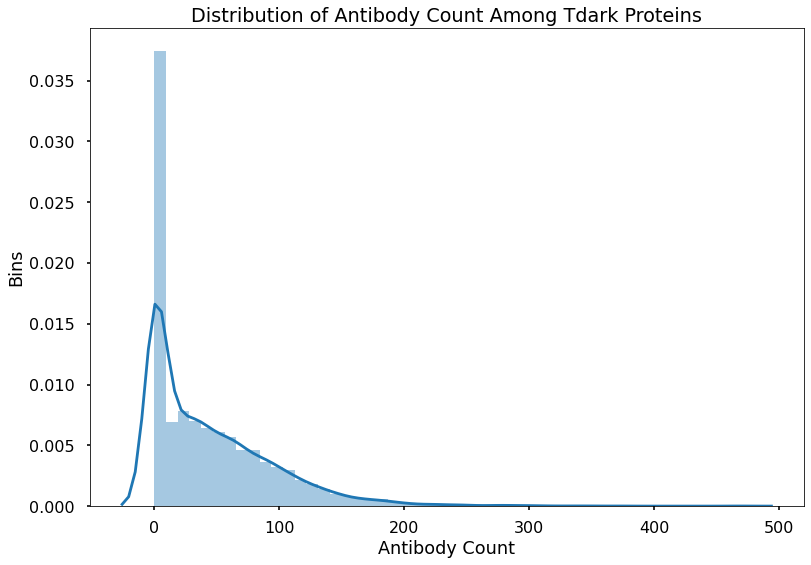

In [4]:
sns.distplot(targets['ab_count'])
plt.xlabel('Antibody Count')
plt.ylabel('Bins')
plt.title('Distribution of Antibody Count Among Tdark Proteins')

* Right Skewed as expected

In [5]:
ab_req = targets[targets['ab_count'] >= 50]

print('{:.2f}% of {} Tdark proteins have an antibody count over greater than or equal to 50'.format(len(ab_req)/len(targets)*100, len(targets)))

36.78% of 6368 Tdark proteins have an antibody count over greater than or equal to 50


\pagebreak

# PM Scores

In [6]:
# Getting average PM Score for each protein
avg_score = {}

pm_group = pm_scores.groupby(['protein_id'])

for name, group in pm_group:
    avg_score[name] = group['score'].sum()

pm_proteins = targets[targets['id'].isin(avg_score.keys())]

pm_proteins['pm_score'] = avg_score.values()

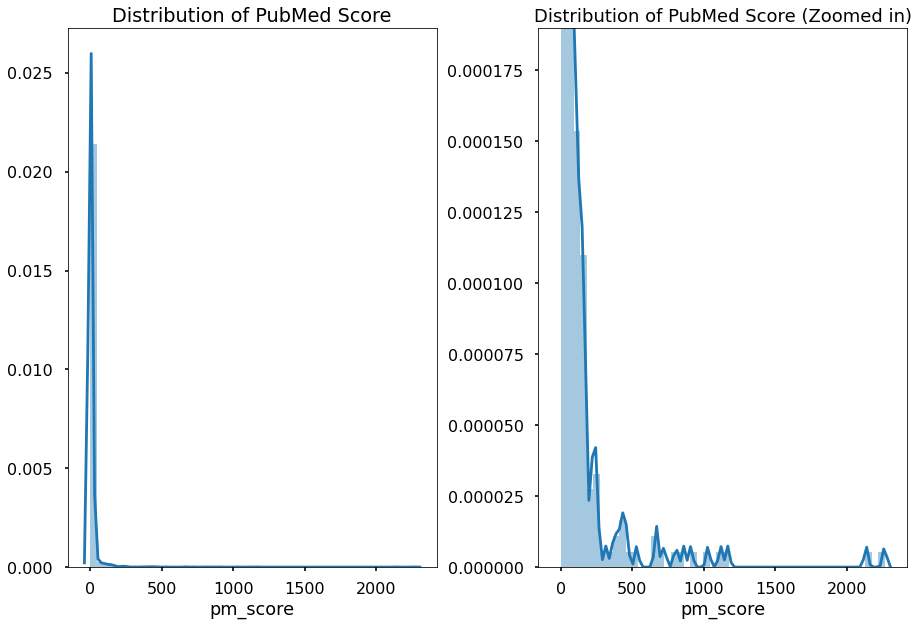

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2)

sns.distplot(pm_proteins.pm_score, ax=ax[0])

sns.distplot(pm_proteins.pm_score, ax=ax[1])

ax[0].set_title('Distribution of PubMed Score')
ax[1].set_ylim(0,0.00019)
ax[1].set_title('Distribution of PubMed Score (Zoomed in)', fontsize=18)
plt.tight_layout()

\pagebreak

# Gene RIF

In [8]:
proteins = {}
generif_group = generif.groupby(['protein_id'])

for name, group in generif_group:
    proteins[name] = len(group)

generif_df = targets[targets.id.isin(proteins.keys())]
generif_df['rif'] = proteins.values()

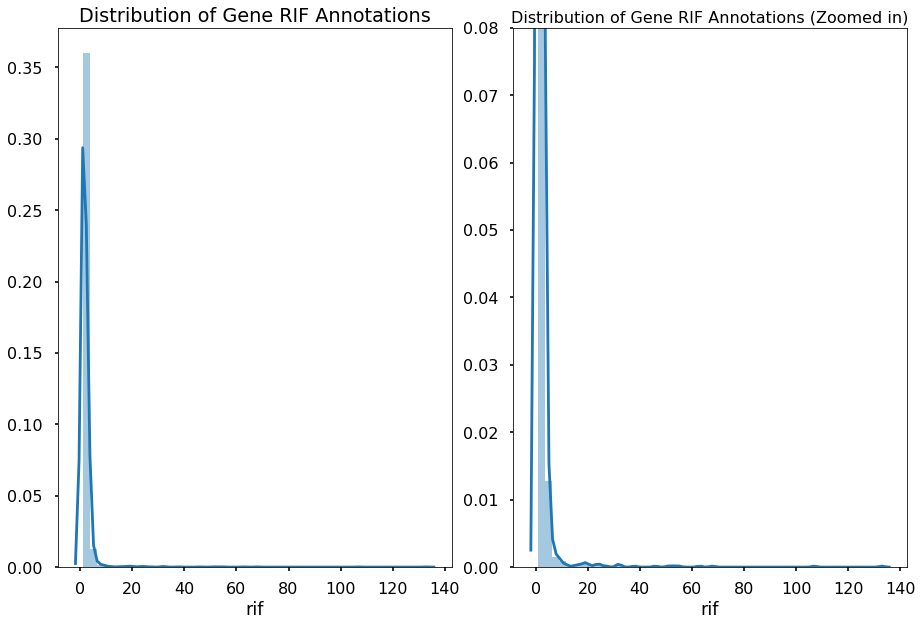

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2)

sns.distplot(generif_df.rif, ax=ax[0])

sns.distplot(generif_df.rif, ax=ax[1])

ax[0].set_title('Distribution of Gene RIF Annotations')
ax[1].set_ylim(0,0.08)
ax[1].set_title('Distribution of Gene RIF Annotations (Zoomed in)', fontsize=16)
plt.tight_layout()

\pagebreak

# Thresholds used for filtering Ripe Proteins

In [10]:
proteins_with_data = targets[(targets['id'].isin(generif['protein_id'])) & (targets['id'].isin(pm_scores['protein_id']))]

proteins_with_data['generif'] = generif_df.rif
proteins_with_data['pm_score'] = pm_proteins.pm_score

In [11]:
ripe_proteins = proteins_with_data[(proteins_with_data.ab_count >= 40) & (proteins_with_data.generif >= 2) & (proteins_with_data.pm_score >= 4)]

ripe_proteins.sort_values(['ab_count', 'generif', 'pm_score'], ascending=False, inplace=True)

\pagebreak

# Proteins Close to Moving up a Level by PubMed Score

In [12]:
by_pm = ripe_proteins[(ripe_proteins['ab_count'] >= 50) & (ripe_proteins['generif'] >= 3) & (ripe_proteins['pm_score'] > 3)].sort_values('pm_score', ascending=False)

for i in by_pm['name']:
    print(i)

Protein phosphatase 1 regulatory subunit 12C
Muscular LMNA-interacting protein
C1q-related factor
Interleukin-17 receptor E
Deuterosome assembly protein 1
Glutathione-specific gamma-glutamylcyclotransferase 2
Arf-GAP with coiled-coil, ANK repeat and PH domain-containing protein 3
NF-kappa-B inhibitor-interacting Ras-like protein 2
Spermatogenesis-associated protein 17
Phospholipid phosphatase 2
Tetraspanin-31
Translocating chain-associated membrane protein 1
MBT domain-containing protein 1
Rho guanine nucleotide exchange factor 19
Serine-rich coiled-coil domain-containing protein 1
ATP-dependent (S)-NAD(P)H-hydrate dehydratase
Ras and Rab interactor-like protein
F-box/LRR-repeat protein 20
Kelch domain-containing protein 8B
Centrosomal protein of 41 kDa
Inactive serine protease 35
Dual specificity protein phosphatase 19
Tudor and KH domain-containing protein
Helicase ARIP4
Phospholipid-transporting ATPase ID
Zinc finger CW-type PWWP domain protein 1
Fc receptor-like protein 6
Endoplasm

\pagebreak

# By Gene RIF

In [13]:
by_rif = ripe_proteins[(ripe_proteins['ab_count'] >= 50) & (ripe_proteins['generif'] == 2) & (ripe_proteins['pm_score'] >= 5)].sort_values('generif', ascending=False)

for i in by_rif['name']:
    print(i)

Coiled-coil domain-containing protein 85B
Protein YIPF6
Transcription termination factor 3, mitochondrial
Leucine-rich repeat-containing protein 10
HD domain-containing protein 2


\pagebreak

# By Antibody Count

In [14]:
by_ab = ripe_proteins[((ripe_proteins['ab_count'] >= 40) & (ripe_proteins['ab_count'] < 50)) & (ripe_proteins['generif'] >= 3) & (ripe_proteins['pm_score'] >= 5)].sort_values('ab_count', ascending=False)

for i in by_ab['name']:
    print(i)

Prolactin-releasing peptide
Beta-crystallin A2
Alpha-protein kinase 3
Heparan-sulfate 6-O-sulfotransferase 3
Coiled-coil-helix-coiled-coil-helix domain-containing protein 7
Tuberoinfundibular peptide of 39 residues
G patch domain-containing protein 2
Uncharacterized protein C11orf95
Protein ATP1B4
Histone H1t
DnaJ homolog subfamily C member 21
Transmembrane protein 185A
Olfactory receptor 1A1
Kinase non-catalytic C-lobe domain-containing protein 1
Lysophospholipid acyltransferase LPCAT4
Nascent polypeptide-associated complex subunit alpha-2
SUN domain-containing protein 3
Tumor necrosis factor alpha-induced protein 8-like protein 1
Cadherin-like and PC-esterase domain-containing protein 1
MAU2 chromatid cohesion factor homolog
Protein SFI1 homolog
Serine protease inhibitor Kazal-type 2
Calpain-14
Glutathione peroxidase 6
Lipoyltransferase 1, mitochondrial
Solute carrier family 10 member 6
Ras GTPase-activating protein 2
Immunoglobulin-like domain-containing receptor 2


\pagebreak

# Looking how Source Frequency Correlates with Protein "Ripeness"

Text(0.5, 1.0, 'Frequency of Sources in Ripe Proteins')

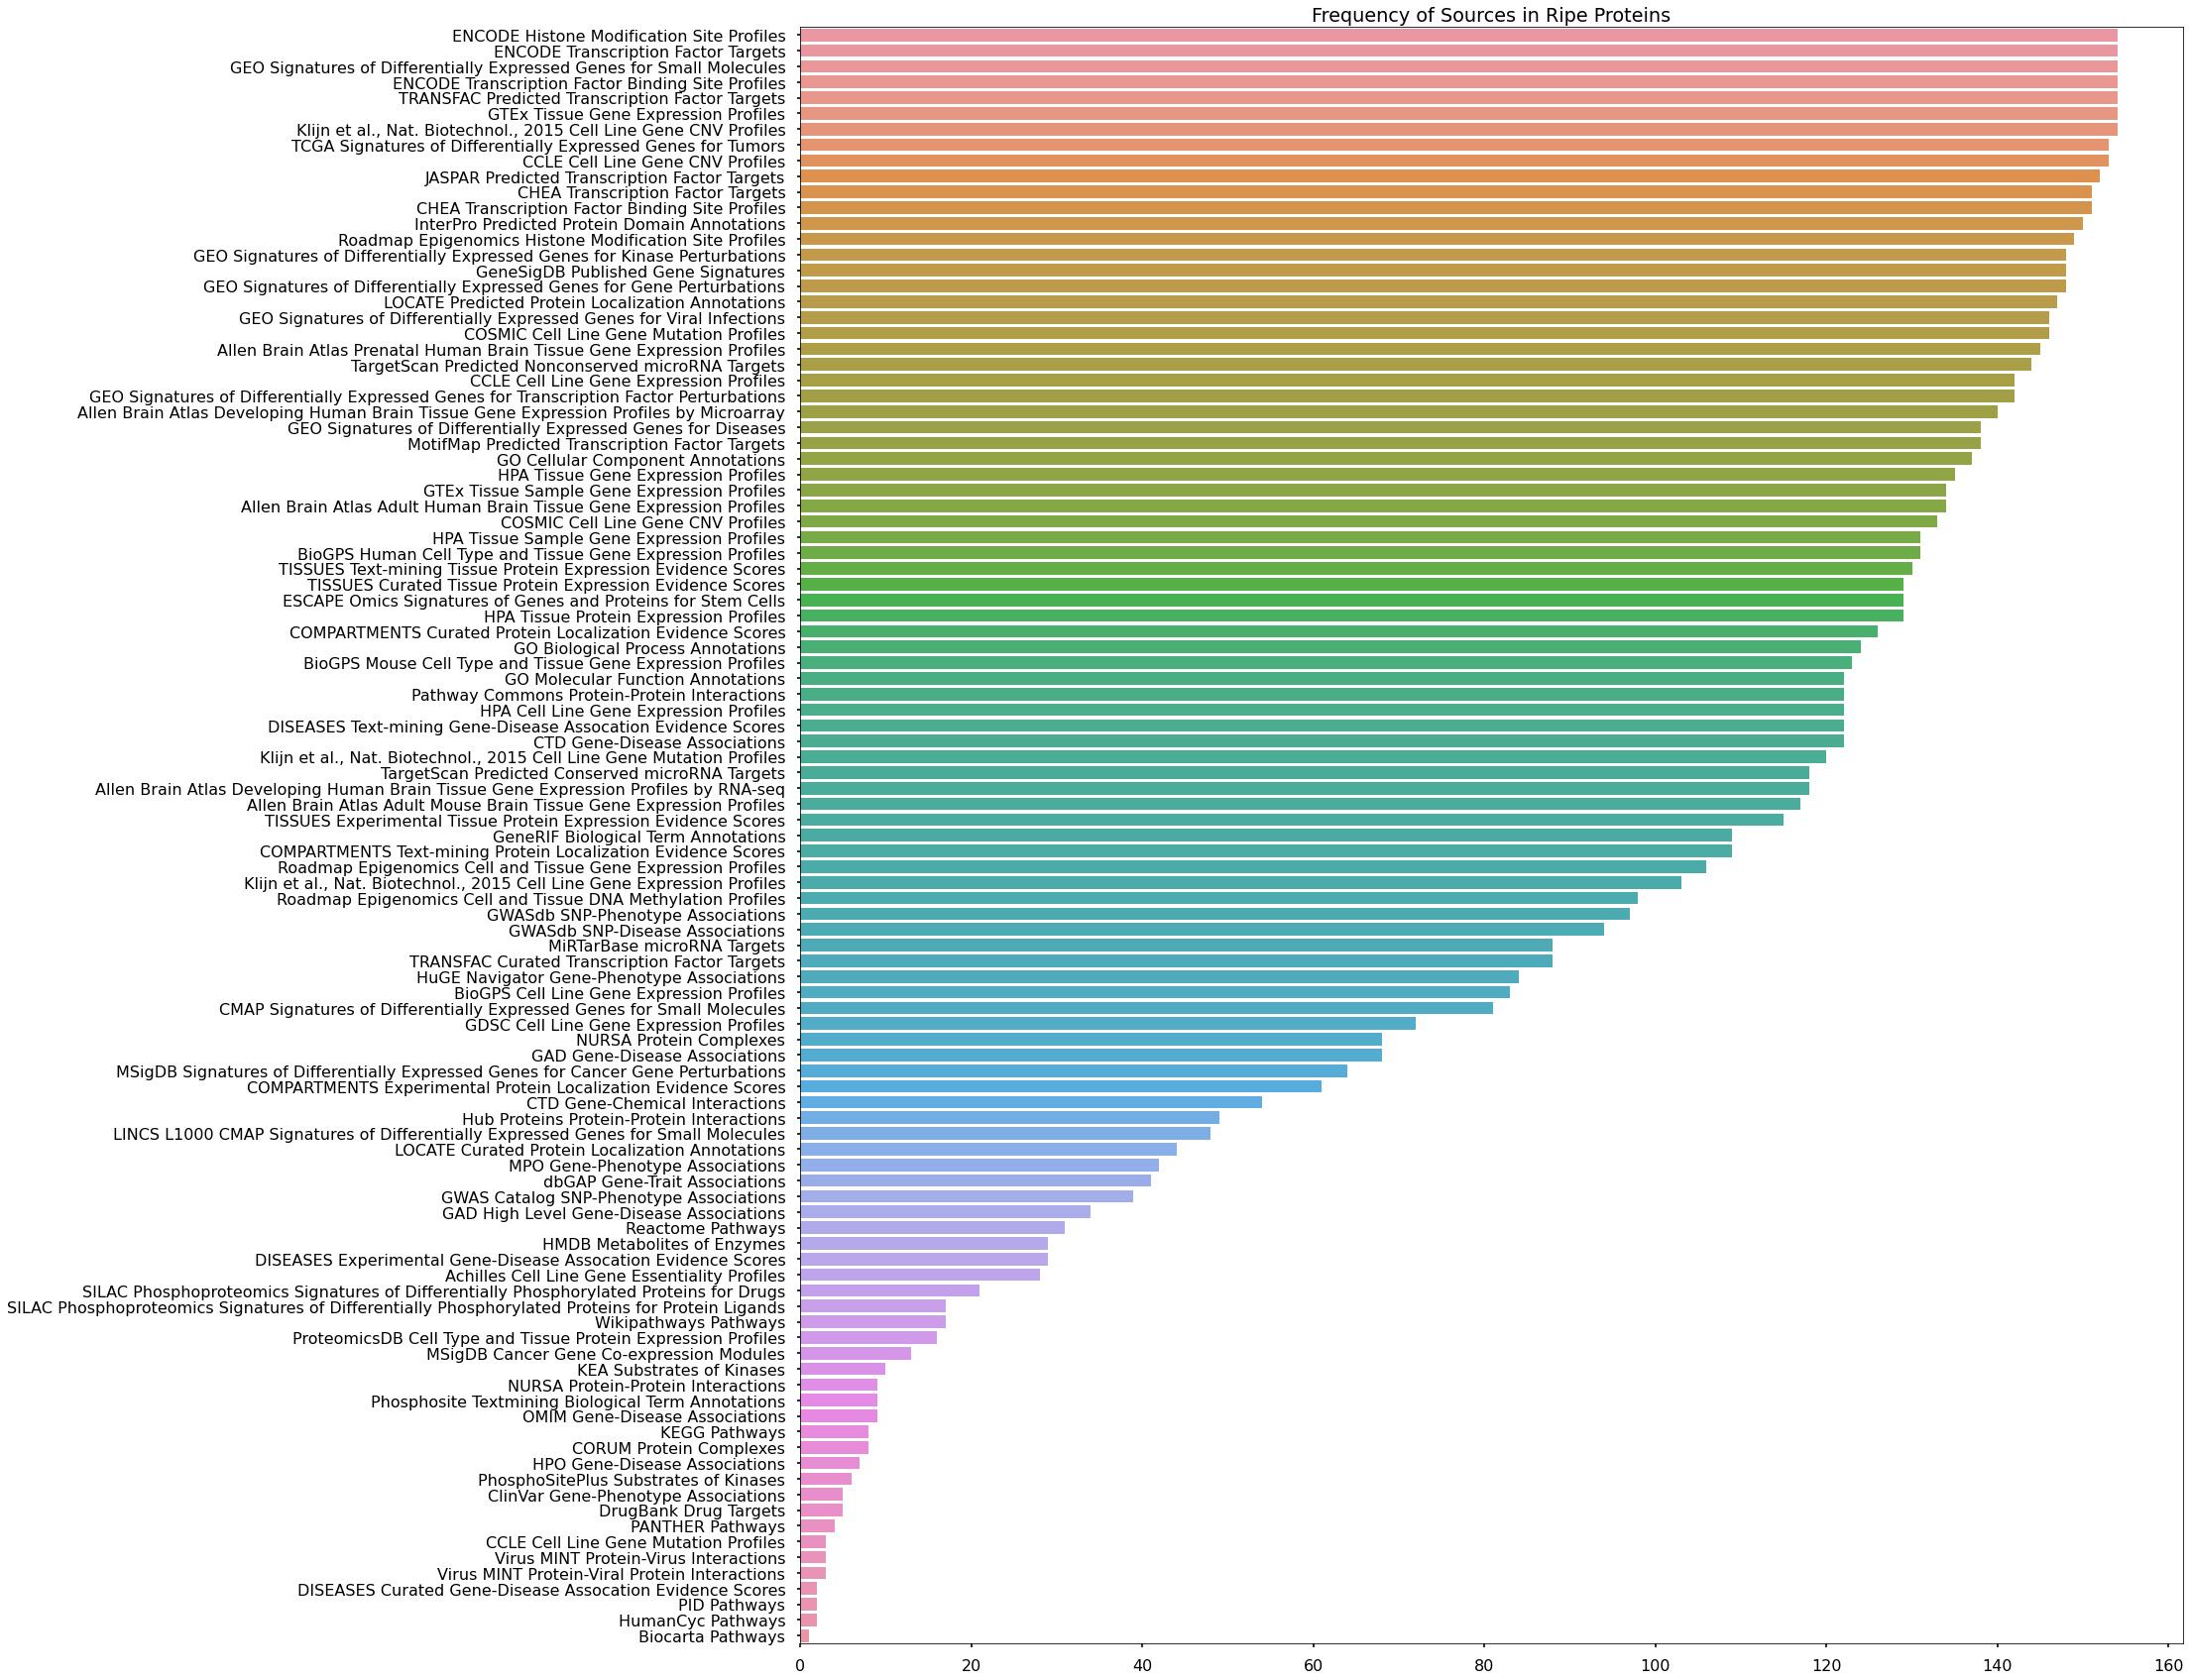

In [15]:
hgram_ripe = hgram[hgram['protein_id'].isin(ripe_proteins['id'])]

type_counts = hgram_ripe['type'].value_counts().sort_values(ascending=False)

ripe_source_counts = type_counts.keys()
plt.figure(figsize=(25,30))
sns.barplot(y=type_counts.keys(), x=type_counts.values)
plt.title('Frequency of Sources in Ripe Proteins')

\pagebreak


Text(0.5, 1.0, 'Frequency of Sources in Non-Ripe Proteins')

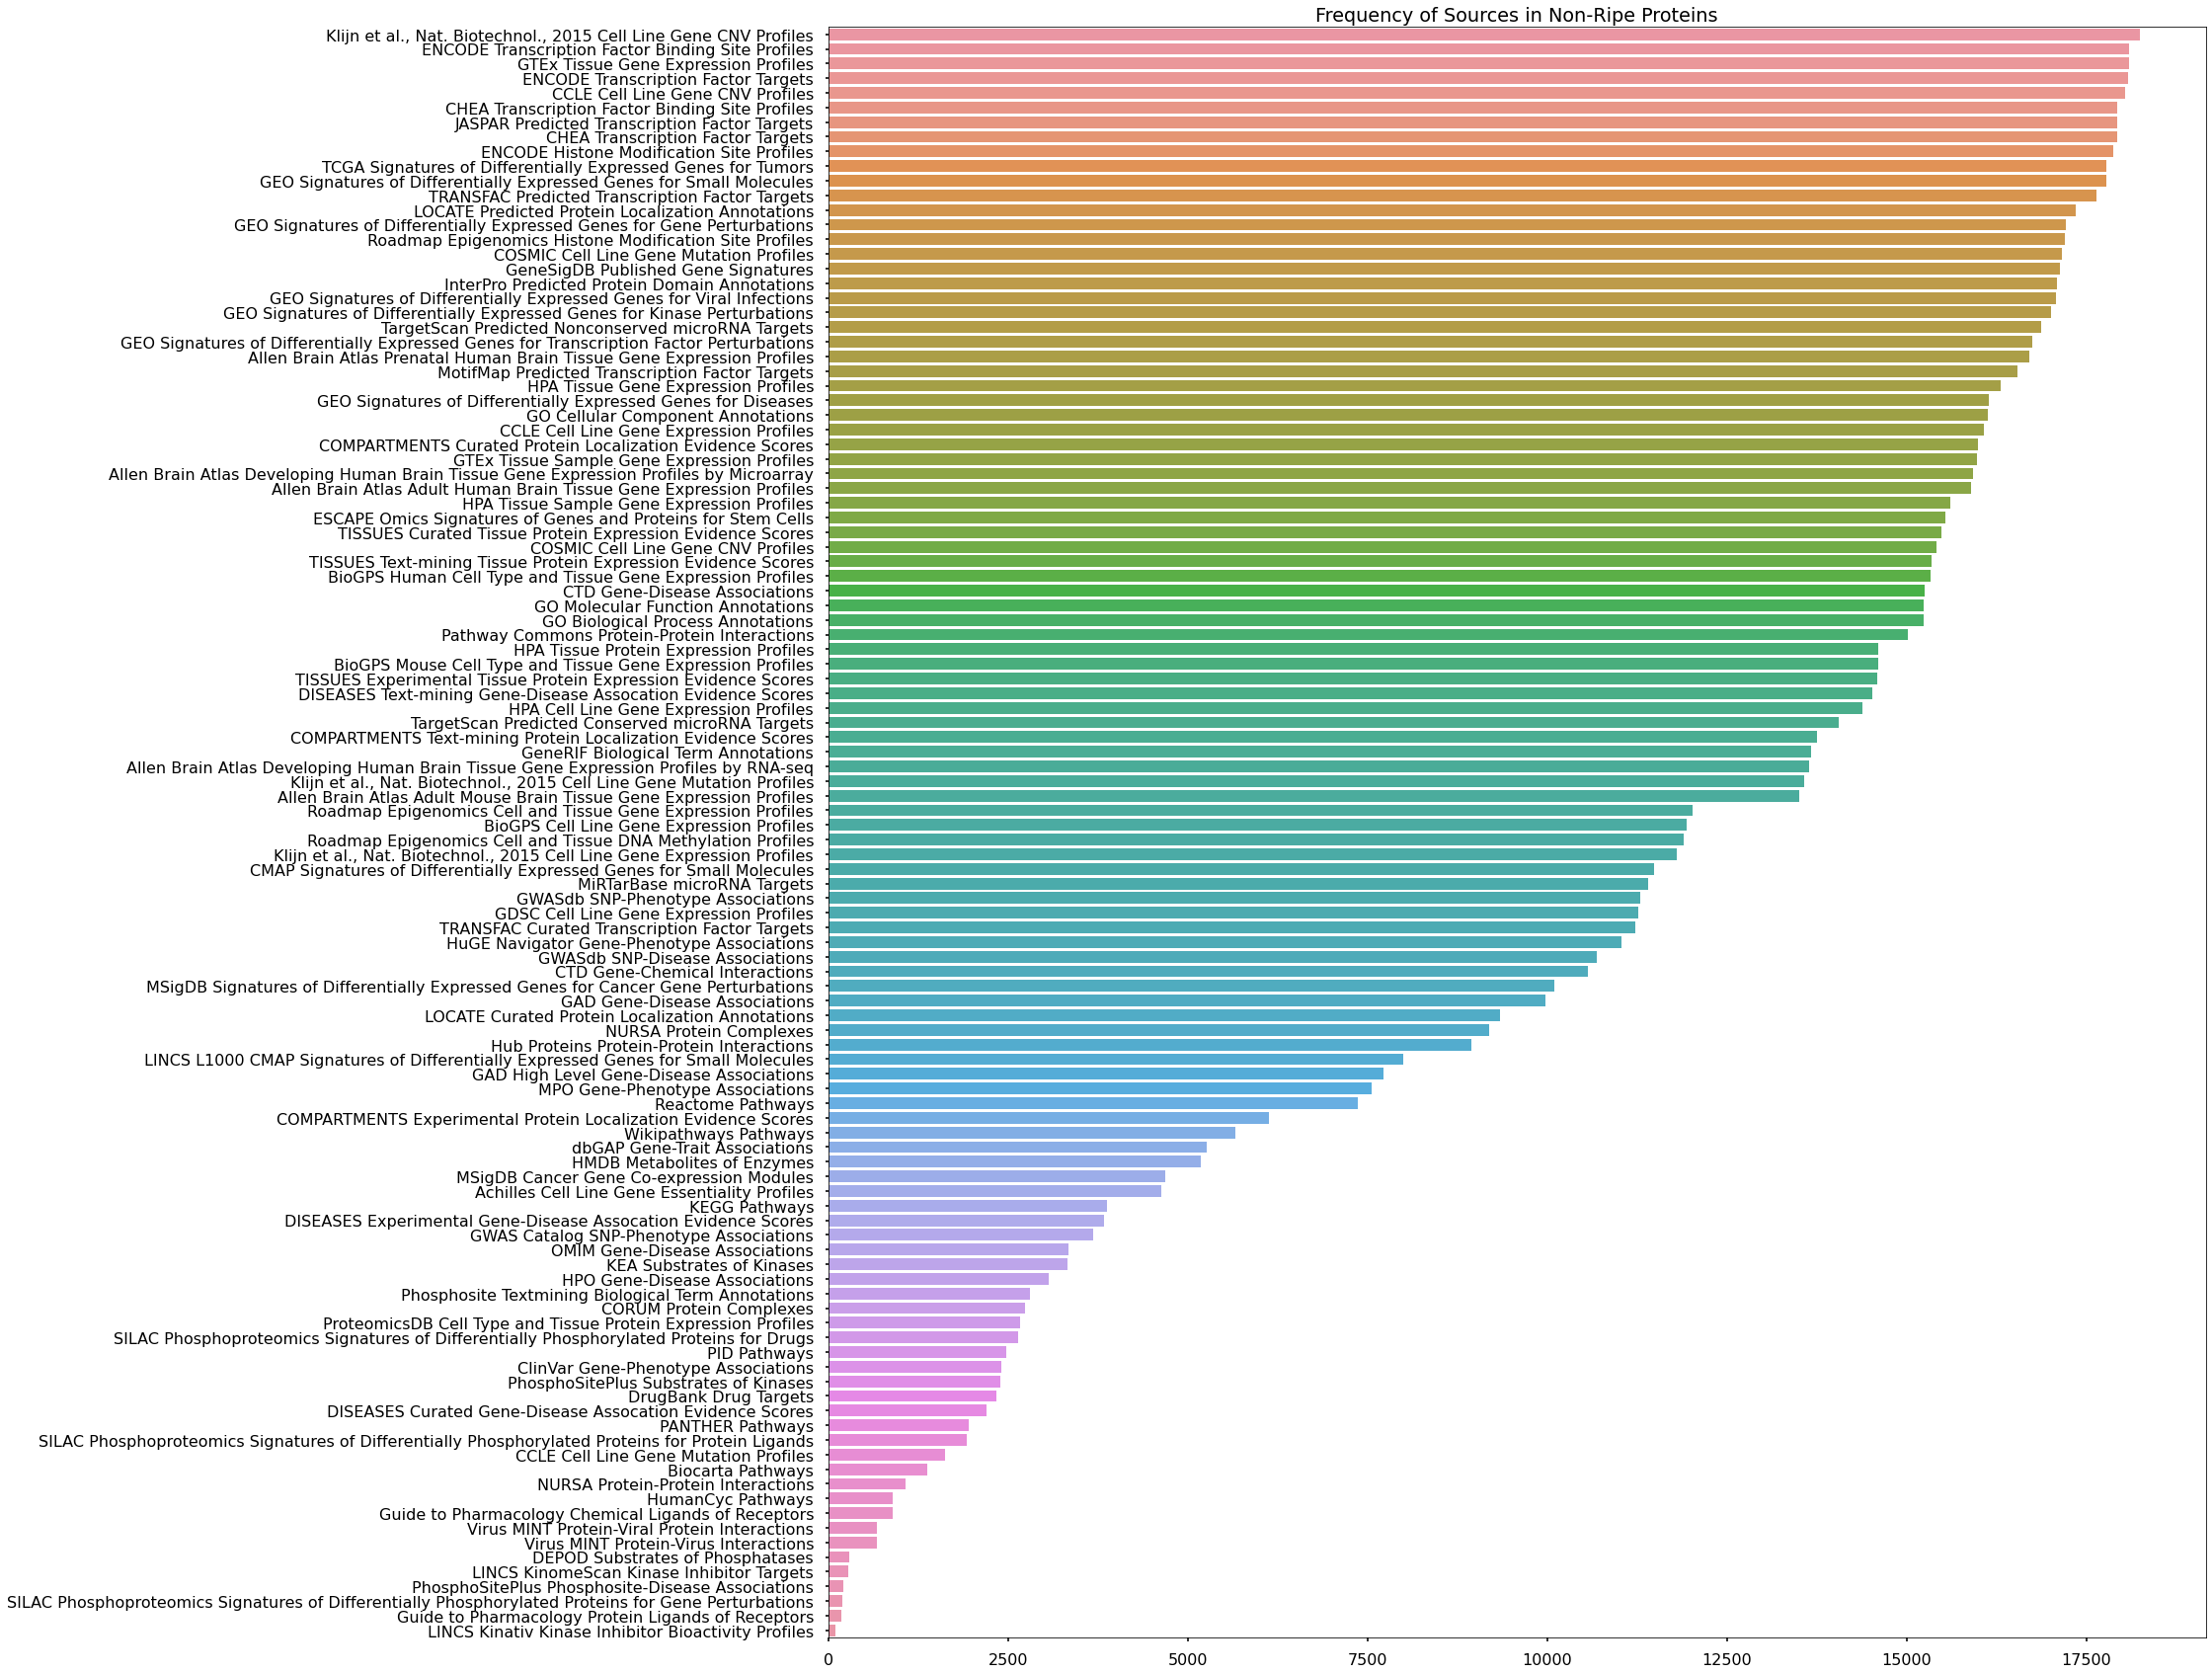

In [16]:
non_ripe_tdark = hgram[~hgram['protein_id'].isin(ripe_proteins['id'])]
type_count_not_ripe = non_ripe_tdark['type'].value_counts().sort_values(ascending=False)

non_ripe_source_counts = type_count_not_ripe.keys()
plt.figure(figsize=(25,30))
sns.barplot(y=type_count_not_ripe.keys(), x=type_count_not_ripe.values)
plt.title('Frequency of Sources in Non-Ripe Proteins')

The actual shapes of the histrograms look similar, but the positions of different sources are not identical.

The way I will assess these differences is by comparing the "distance" of positions of the source in the ripe proteins chart to the non-ripe proteins chart.

For example: 
GTEx Tissue Gene Expression Profiles is in spot 1 in the ripe proteins chart and is in spot 3 in the non-ripe proteins chart.

Therefore, this source would have a distance of 2. 

If the result were to be negative, that would mean that the source in the non ripe proteins chart is placed higher than the ripe protein chart.

\pagebreak

# Looking how Source Frequency Correlates with Protein “Ripeness”

In [17]:
ripe_sources = ripe_source_counts
non_ripe_sources = non_ripe_source_counts

distances = {}

for i in range(len(ripe_sources)):
    distance = 0
    starting_point = i
    for j in non_ripe_source_counts:
        if ripe_sources[i] == j:
            distances[ripe_sources[i]] = (distance+1) - starting_point
            break
        distance+=1
distances = {k: v for k, v in sorted(distances.items(), key=lambda item: item[1], reverse=True)}

source_distances = pd.DataFrame(list(zip(distances.keys(), distances.values())), columns=['Source', 'distance'])

Text(0.5, 1.0, 'Sources with a Distance of Four or More')

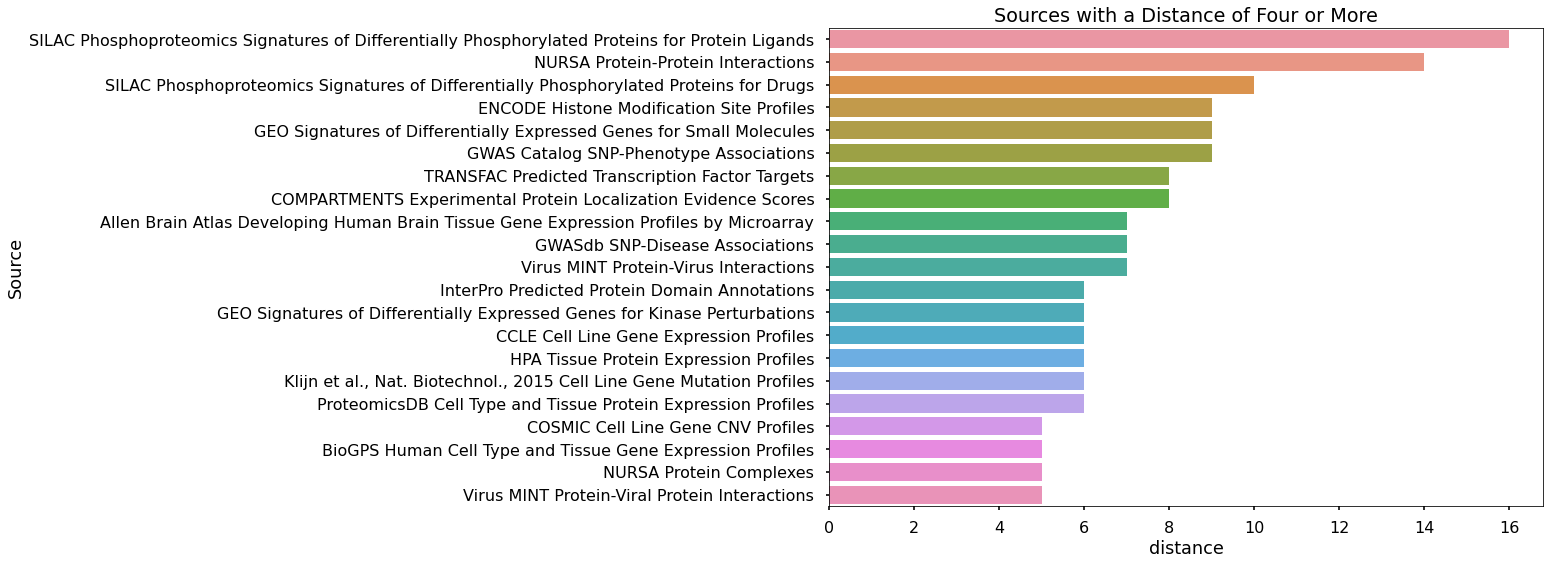

In [18]:
dist_thresh = source_distances[source_distances['distance'] > 4]

sns.barplot(data=dist_thresh, y='Source', x='distance')
plt.title('Sources with a Distance of Four or More')

I think it is pretty interesting that SILAC's publications are not common at all in the "non-ripe" protein batch.

The fact that the amount of sources in the ripe protein batch is 9,153, while the non-ripe protein batch has 1,158,727, shows that any distance of a surmountable size means there is some sort of correlation.

It seems that the histogram data (also called the Radar Circle) in Pharos can potentially help find proteins that could be moving up from Tdark to Tbio